# Difference-in-Difference (Diff-in-Diff)

## Import libraries

In [1]:
#!pip install matplotlib seaborn statsmodels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as smp
import statsmodels.formula.api as sm

import joblib

In [3]:
from clickhouse_driver import Client


user_name = 'user_name'
pwd = 'password'

# creating connection ClickHouse
client = Client(host='clickhouse.lab.karpov.courses', port=9000,
                user=user_name, password=pwd, database='hardda')

# checking connection
result = client.execute("SELECT * FROM hardda.user_dm_events LIMIT 1")

# showing the result
for row in result[0:1]:
    print(row)

(datetime.date(2022, 2, 1), datetime.date(2022, 1, 31), 'android', 'f7411212fd0e2523e126cbfdd3f226c211212', '4beb10e1-aeeb-4c52-acd2-ce1ddbc1fc24b10e1', 22, 11, 3, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0)


## Tasks

### Task 1.

 **Write an SQL query to get `event_date`, `platform`, `cnt_view_advertisement`, `contact`, `cr` from `user_dm_events` between 2022-01-01 and 2022-06-07.**

In [4]:
query = '''
SELECT
  event_date,
  platform,
  SUM(cnt_view_advertisement) AS cnt_view_advertisement,
  SUM(cnt_display_phone + cnt_send_message) AS contact
FROM
  user_dm_events
WHERE
  event_date BETWEEN '2022-01-01' and '2022-06-07'
GROUP BY
  event_date,
  platform
'''

In [5]:
result = client.execute(query)

In [6]:
len(result)

254

In [7]:
df = pd.DataFrame(result, columns=['event_date', 'platform',
                                   'cnt_view_advertisement', 'contact'])

df

,event_date,platform,cnt_view_advertisement,contact
0,2022-06-02,android,1475717,80184
1,2022-04-18,ios,633205,47158
2,2022-02-19,ios,507738,35602
3,2022-03-30,android,1775406,97654
4,2022-05-28,android,1415007,73005
...,...,...,...,...
249,2022-06-04,android,1370559,74468
250,2022-03-27,android,1992935,102864
251,2022-04-23,ios,582899,41781
252,2022-02-16,ios,538275,40988


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_date              254 non-null    object
 1   platform                254 non-null    object
 2   cnt_view_advertisement  254 non-null    int64 
 3   contact                 254 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 8.1+ KB


In [9]:
df['event_date'] = pd.to_datetime(df['event_date'], format='%Y-%m-%d')

In [10]:
df['cr'] = df['contact'] / df['cnt_view_advertisement']
df = df.sort_values(['event_date', 'platform'])
df.reset_index(drop=True, inplace=True)

In [11]:
df

,event_date,platform,cnt_view_advertisement,contact,cr
0,2022-02-01,android,1946760,99032,0.050870
1,2022-02-01,ios,560769,39480,0.070403
2,2022-02-02,android,1936104,98353,0.050799
3,2022-02-02,ios,558109,40839,0.073174
4,2022-02-03,android,1890293,98558,0.052139
...,...,...,...,...,...
249,2022-06-05,ios,483311,32807,0.067880
250,2022-06-06,android,1513920,82766,0.054670
251,2022-06-06,ios,496689,35916,0.072311
252,2022-06-07,android,1439363,83625,0.058099


### Task 2.  

**What an avarage daily contact number for Android?** 

In [12]:
df[df['platform'] == 'android'].contact.mean()

94377.94488188977

### Task 3. 

**Find fixed horizon sample size to detect 0.05 relative effect on our data.** 

In [13]:
df[df['platform'] == 'ios'].cnt_view_advertisement.mean()

536590.1181102362

### Task 4. 

**Build a chart of the metric dynamics by platform and visually look at the dynamics before and after the change introduced on 2022-06-01.**

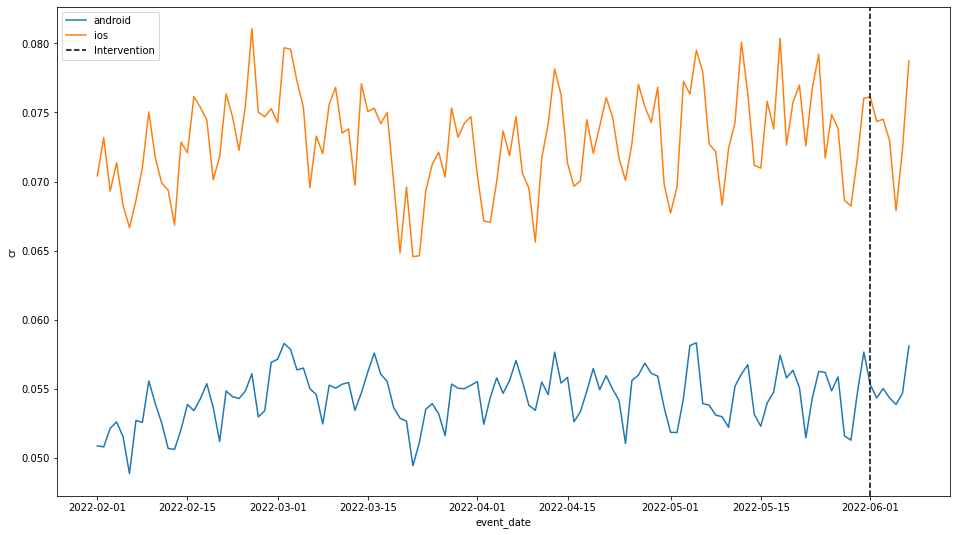

In [14]:
plt.figure(figsize=(16, 9))

sns.lineplot(df, x='event_date', y='cr', hue='platform')
plt.axvline(pd.to_datetime('2022-06-01'), color = 'black', linestyle = '--', label = 'Intervention')
plt.legend();

### Task 5. 

**Evaluate whether the trends are parallel using the Dickey-Fuller test. Indicate the average difference between the series in the pre period.**

In [15]:
df['intervention'] = np.where(df.event_date >= '2022-06-01', 1, 0)
df['treatment'] = np.where(df.platform == 'android', 1, 0)

p-value test D-Fuller = 0.000000
Are trends parallel? -> True


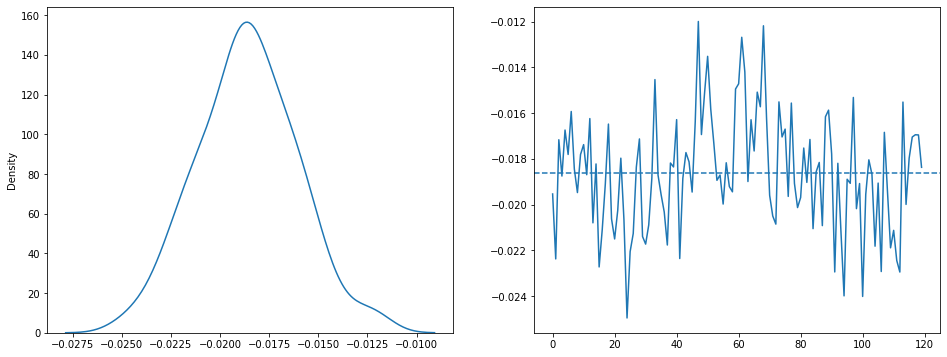

In [16]:
y_pre = np.array(df[(df['intervention'] == 0) & (df['platform'] == 'android')].cr)
x0_pre = np.array(df[(df['intervention'] == 0) & (df['platform'] == 'ios')].cr)
diff = y_pre - x0_pre
DF_pval = smp.tsa.stattools.adfuller(diff)[1]
print('p-value test D-Fuller = %f' % DF_pval)
print('Are trends parallel? ->', DF_pval < 0.05)
fig,axes = plt.subplots(1, 2, figsize=(16,6))
sns.kdeplot(ax=axes[0], data = diff)
axes[1].plot(diff)
axes[1].axhline(y = np.mean(diff),ls = '--');

In [17]:
diff.mean()

-0.01861212257583366

### Task 6. 

**Can we reject H0 using Diff-in-Diff approach?**

In [18]:
formula = 'cr ~ treatment + intervention + treatment * intervention'
model = sm.ols(formula = formula, data = df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     905.7
Date:                Sat, 25 Nov 2023   Prob (F-statistic):          6.06e-134
Time:                        14:14:05   Log-Likelihood:                 1130.4
No. Observations:                 254   AIC:                            -2253.
Df Residuals:                     250   BIC:                            -2239.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

`treatment:intervention` p-value = 0.932, we are not able to reject H0. 

### Task 7. 

**What is absolute Diff-in-Diff value?**

In [19]:
df_s_r = df.pivot_table(values = 'cr', index = 'intervention', columns = 'treatment', aggfunc = 'mean')
df_s_r['diff'] = df_s_r.iloc[:, 1] - df_s_r.iloc[:, 0]

diff_in_diff_r = df_s_r.iloc[1, -1] - df_s_r.iloc[0, -1]

print('Absolute Diff-in-Diff =', np.abs(diff_in_diff_r))
df_s_r

Absolute Diff-in-Diff = 0.00013297244115732104


treatment,0,1,diff
intervention,,,
0,0.072975,0.054363,-0.018612
1,0.073835,0.055089,-0.018745


### Task 8. 

**Run simulation to find I and II type errors for effect size = [0.9, 0.95, 0.975, 1., 1.025, 1.05, 1.1], where 1 means no effect.**

Use the following simulation parameters:

* covariate — 'android'
* n_days = 7
* control_percent = 0.7
* n_sim = 100

In [20]:
def causal_analysis(data, control_group, n_days = 14, control_percent = 0.7, sample_n = 50):
    '''
    data - historical data, on which we will run the test check
    control_group - the name of the variable forming the control group
    n_days - the number of days in the test period. i.e. how long we expect the post-period to go in days
        It should be set so that the size of n_days does not exceed the 1-control_percent share of test data. 
        Therefore, the percentage of 1-control_percent should be set with some margin
    control_percent - the share of historical data that we reserve for the control period. 
        For example, not less than 70%
    sample_n -  the number of simulations. How many times do we run the simulation for each effect being checked 
        (by default 7 effects in the code: [0.9, 0.95, 0.975, 1., 1.025, 1.05, 1.1])

    '''
    n_days -= 1

    df_copy = data.copy()
    effects = [0.9, 0.95, 0.975, 1., 1.025, 1.05, 1.1] # list off effects. 1 = means no effect (A/A test)
    rel_effects = []

    dates = pd.DataFrame({'post_period_0': data.index}) # Даты

    # the first event_date for a control group
    initial = dates.values[0][0]
    # Test group, we select sample_n random dates from it in the test period,
    # i.e. sample_n dates after control_percent days.
    # We are kind of randomly choosing days of the start of the innovation in the test zone dates range
    test = dates.iloc[int(len(dates)*(control_percent)):-n_days]\
                .sample(sample_n, random_state = 123, replace = True)\

    # Defining PRE and POST data periods based on the test period random date we get
    test['post_period_1'] = test.post_period_0 + pd.DateOffset(days = n_days)
    test['pre_period_0'] = initial
    test['pre_period_1'] = test.post_period_0 - pd.DateOffset(days = 1)

    test = test.astype(str)
    a = np.empty((sample_n, len(effects) + 2))

    def calculate_sse_mape_pval(d):
        sse = []
        mape = []
        p_vals = []
        for i in range(len(effects)):
            pre_period = [test.pre_period_0.values[d], test.pre_period_1.values[d]]
            post_period = [test.post_period_0.values[d], test.post_period_1.values[d]]

            # dataset to evaluate effects
            df_copy = data.copy() 
            
            # choosing intervention
            df_copy['intervention'] = 0
            df_copy.loc[post_period[0]:post_period[1], 'intervention'] = 1

            df_copy.loc[np.logical_and(
                        df_copy.index >= post_period[0], df_copy.index <= post_period[1]), 'y'] *= effects[i] # задаём эффект

            df_copy = pd.melt(df_copy.reset_index(), id_vars = ['index', 'intervention'], value_vars = ['y', control_group],
                 var_name = 'variable', value_name = 'value')
            df_copy['treatment'] = np.where(df_copy.variable == 'y', 1, 0)

            formula = 'value ~ treatment + intervention + treatment * intervention'
            model = sm.ols(formula = formula, data = df_copy)
            res = model.fit()

            b0 = res.params['Intercept']
            b1 = res.params['treatment']
            b2 = res.params['intervention']
            b3 = res.params['treatment:intervention']

            # calculating Diff-in-Diff
            rel_diff_in_diff = ((b0 + b1 + b2 + b3) / (b0 + b1)) / ((b0 + b2) / b0) - 1

            real_eff = effects[i] - 1
            to_sse = pow(rel_diff_in_diff - real_eff, 2) # diff-in-diff Sum of Squared Erros
            to_mape = abs(rel_diff_in_diff - real_eff) * 100 # diff-in-diff Mean Absolute Percentage Error

            sse.append(to_sse)
            mape.append(to_mape)
            rel_effects.append(rel_diff_in_diff)
            p_vals.append(res.pvalues['treatment:intervention'])

        return (d, sum(sse), np.mean(mape), p_vals[effects.index(1)], p_vals[effects.index(1.025)],
               p_vals[effects.index(0.975)], p_vals[effects.index(1.05)], p_vals[effects.index(0.95)],
               p_vals[effects.index(1.1)], p_vals[effects.index(0.9)])

    results = joblib.Parallel(n_jobs=-1, verbose = len(test))(joblib.delayed(calculate_sse_mape_pval)(d) for d in range(len(test)))

    for result in results:
        d = result[0]
        a[d][0] = result[1]
        a[d][1] = result[2]
        a[d][2] = result[3]
        a[d][3] = result[4]
        a[d][4] = result[5]
        a[d][5] = result[6]
        a[d][6] = result[7]
        a[d][7] = result[8]
        a[d][8] = result[9]

    aa = pd.DataFrame(a, columns = ['sse', 'mape', 'p_val_1', 'p_val_1_025', 'p_val_0_975',
                                    'p_val_1_05', 'p_val_0_95', 'p_val_1_1', 'p_val_0_9'])
    final = test.reset_index().merge(aa.reset_index(), left_index = True, right_index = True)
    final.drop(columns = ['index_x', 'index_y'], inplace = True)
    final['control_group'] = control_group
    
    return final

In [21]:
ts_data = df.query("event_date < '2022-06-01'")\
              .pivot_table(values = 'cr', index = 'event_date', columns = 'platform')
ts_data.rename(columns = {'ios': 'y'}, inplace = True)
ts_data.index.name = None
ts_data

platform,android,y
2022-02-01,0.050870,0.070403
2022-02-02,0.050799,0.073174
2022-02-03,0.052139,0.069300
2022-02-04,0.052607,0.071356
2022-02-05,0.051540,0.068276
...,...,...
2022-05-27,0.055862,0.073830
2022-05-28,0.051593,0.068635
2022-05-29,0.051281,0.068223
2022-05-30,0.054716,0.071668


In [22]:
%%time
covariate_name = 'android'
days = 7
control_percent = 0.7
n_sim = 100


res = pd.DataFrame()
caus = causal_analysis(ts_data, covariate_name, days, control_percent, n_sim)
res = pd.concat([res, caus], axis = 0)
res.sample(5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

,post_period_0,post_period_1,pre_period_0,pre_period_1,sse,mape,p_val_1,p_val_1_025,p_val_0_975,p_val_1_05,p_val_0_95,p_val_1_1,p_val_0_9,control_group
11,2022-04-27,2022-05-03,2022-02-01,2022-04-26,3.394787e-07,0.021981,0.992051,0.246302,0.253377,0.021650,0.022177,6.825756e-06,0.000006,android
64,2022-05-09,2022-05-15,2022-02-01,2022-05-08,8.346883e-04,1.089934,0.662468,0.112052,0.470014,0.006419,0.060393,8.779439e-07,0.000035,android
81,2022-05-03,2022-05-09,2022-02-01,2022-05-02,1.861969e-03,1.627888,0.370301,0.037903,0.767994,0.001217,0.137257,4.865600e-08,0.000130,android
16,2022-04-26,2022-05-02,2022-02-01,2022-04-25,1.681583e-04,0.489212,0.863796,0.327875,0.185955,0.034214,0.013694,1.502602e-05,0.000003,android
51,2022-04-28,2022-05-04,2022-02-01,2022-04-27,1.512149e-05,0.146702,0.979150,0.260363,0.237847,0.023516,0.019943,7.741925e-06,0.000005,android


In [23]:
# function to aggregate simulations result
def to_res(data, to_group, n, alpha = 0.05): 
    def p_val_count_alpha(p_val):
        return np.count_nonzero(p_val < alpha) # I-type error count

    def p_val_count_beta(p_val):
        return np.count_nonzero(p_val >= alpha) # II-type error count

    p_val_cols = data.filter(like = 'p_val').columns

    data['pre_period_diff'] = (pd.to_datetime(data.pre_period_1) - pd.to_datetime(data.pre_period_0))
    res = data.groupby([to_group]).agg({'sse': 'sum', # Sum of Squared Errors
                                     'mape': 'mean', # Mean Absolute Percentage Error
                                     p_val_cols[0]: p_val_count_alpha, # I-type error
                                     p_val_cols[1]: p_val_count_beta, # from here and below: II-type errro for each effect size
                                     p_val_cols[2]: p_val_count_beta,
                                     p_val_cols[3]: p_val_count_beta,
                                     p_val_cols[4]: p_val_count_beta,
                                     p_val_cols[5]: p_val_count_beta,
                                     p_val_cols[6]: p_val_count_beta,
                                     'pre_period_diff': 'mean'})

    res[p_val_cols[0]] = res[p_val_cols[0]] / n # dividing by the number of simulations n
    res[p_val_cols[1]] = res[p_val_cols[1]] / n
    res[p_val_cols[2]] = res[p_val_cols[2]] / n
    res[p_val_cols[3]] = res[p_val_cols[3]] / n
    res[p_val_cols[4]] = res[p_val_cols[4]] / n
    res[p_val_cols[5]] = res[p_val_cols[5]] / n
    res[p_val_cols[6]] = res[p_val_cols[6]] / n

    return res

In [24]:
res_conc = to_res(res, 'control_group', n_sim)
res_conc

,sse,mape,p_val_1,p_val_1_025,p_val_0_975,p_val_1_05,p_val_0_95,p_val_1_1,p_val_0_9,pre_period_diff
control_group,,,,,,,,,,
android,0.194715,1.443382,0.0,0.55,1.0,0.03,0.72,0.0,0.0,96 days 16:19:12


In [25]:
res_conc.p_val_0_95

control_group
android    0.72
Name: p_val_0_95, dtype: float64